In [84]:
#importamos las librerías necesarias para el proyecto
import sys
from packaging import version
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [85]:
#este código es para cear una carpeta donde guardemos imágenes de las figuras y pesos
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 10.

Ejercicio: Entrena un MLP profundo en el conjunto de datos MNIST (puedes cargarlo usando tf.keras.datasets.mnist.load_data()). Mira si puedes obtener más del 98% de precisión ajustando manualmente los hiperparámetros. Intenta buscar la tasa de aprendizaje óptima utilizando el enfoque presentado en este capítulo (es decir, aumentando la tasa de aprendizaje exponencialmente, trazando la pérdida y encontrando el punto donde la pérdida se dispara). A continuación, intenta ajustar los hiperparámetros utilizando Keras Tuner con todas las funciones: guarda puntos de control, utiliza early stopping y traza las curvas de aprendizaje usando TensorBoard.r

A CONTINUACIÓN: aplicar Keras Tune


PASO 1: cargamos los datos y comprobamos dimensiones.

In [86]:
#cargamos los datos. Viene predifinido los datos de entrenamiento y los de test
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data() #cargamos MNIST
print('Dimensiones train:', X_train_full.shape, y_train_full.shape)
print('Tipo train:', X_train_full.dtype, y_train_full.dtype) #para uint 8 tenemos 2^8=256, un rango de 0 a 255
print('Dimensiones test:', X_test.shape, y_test.shape)
print('Tipo test:', X_test.dtype, y_test.dtype) #para uint 8 tenemos 2^8=256, un rango de 0 a 255

Dimensiones train: (60000, 28, 28) (60000,)
Tipo train: uint8 uint8
Dimensiones test: (10000, 28, 28) (10000,)
Tipo test: uint8 uint8


PASO 2: Dividimos el set de training para obtener uno de validación que podamos usar en el proceso de cross-validation. Además, aplicamos normalización sobre los valores que vimos en el paso 1 que pueden tomar (uint8)

In [87]:
#vamos a decidir como dividimos el setp ara obtener un set de validación que podamos usar para calcular el loss
rate_validation = 0.1
n_train_full = len(X_train_full)
n_valid = int(rate_validation*n_train_full) #necesitamos que sea un n fijo, y como es un set grande nos da igual aproximar con int
n_train = n_train_full-n_valid #de esta forma podemos dividir perfectamente con intersección vacía entre ambos conjuntos, train y validation set

#normalizamos en el rango posible de valores que pueden tomar, que como dijimos es de 0 a 255
normalization_value = 255. #puntito para asegurar la interpretación como float

#separamos X
X_valid, X_train = X_train_full[:n_valid] / normalization_value, X_train_full[n_valid:] / 255.
#separamos y
y_valid, y_train = y_train_full[:n_valid], y_train_full[n_valid:]
print('X valid', len(X_valid), 'X_train', len(X_train))
print('y valid', len(y_valid), 'y_train', len(y_train))
#también tenemos que normalizar el test
X_test = X_test / normalization_value

X valid 6000 X_train 54000
y valid 6000 y_train 54000


PASO 3: analizamos un poco más los outputs y los datos

1


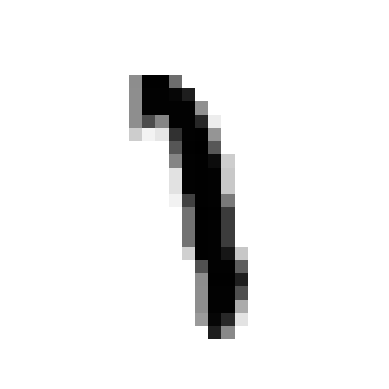

In [88]:
#echamos un vistado a un ejemplo
i = 2
print(y_train[i])
plt.imshow(X_train[i], cmap="binary")
plt.axis('off')
plt.show()

Para y_train los valores son los dígitos representados, por lo que no hace falta ningún encoding.

In [89]:
y_train

array([6, 0, 1, ..., 5, 6, 8], dtype=uint8)

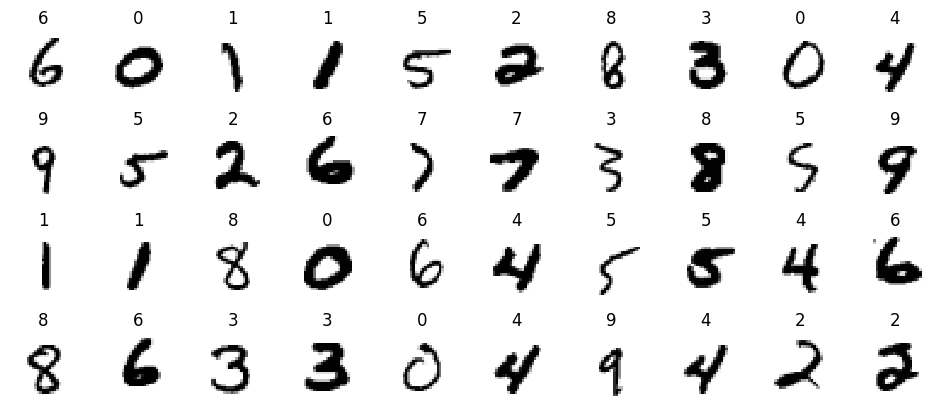

In [90]:
#ahora mostramos todos
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

PASO 4: Vamos finalmente a construir nuestra red. 
Vamos a construir una capa densa (todas las neuronas están conectadas a la capa anterior, así no tenemos que aplicar reglas extras y podemos incializar fácilmente).
Queremos hallar el learning rate óptimo, así que usaremos callbacks.
También se guardará 
Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [91]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback): #definimos la clase que queremos crear cada vez que vayamos a iniciar la red
    def __init__(self, factor): #al principio de la iteración inicializamos para almacenar los valores que deseamos analizar de aprendizaje y loss
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs): #esta función servirá para después de cada batch ir almacenando el learning rate usado y loss obtenido
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [92]:
tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
value_seed = 42 #usamos seed para inicialización aleatoria pero repetición de los datos
np.random.seed(value_seed)
tf.random.set_seed(value_seed)

#construimos la red con la api de keras.
#Este es el caso 3 capas ocultas
model_3layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(300, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"), 
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])

##########################################################################################################################################

value_learning_rate = 1e-3 #valor de inicialización del learning rate
growing_factor = 1.005 #crecimiento del learning rate en un 5% por iteración
optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate) #construimos el optmizador en base a al stochastic gradiente descent
model_3layers.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #compilamos el modelo definiendo la función que queremos usar para el loss, indicándole el optimizador y en qué métrica queremos que se base
expon_lr = ExponentialLearningRate(factor=growing_factor) #aplicamos nuestra clase para poder usar los callbacks y saber el mejor learning rate

PASO 5: Finalmente comenzamos el entrenamiento de la red.

In [93]:

#entrenamos para un sólo epoch. Estos pasos pueden tardar y ser necesario volver para atrás, por lo que se deben vigilar o aplicar early_stopping
#de esa forma evitamos aplicar tiempos excesivos de aprendizaje o el overfitting
history = model_3layers.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1688/1688 [==============================] - 8s 4ms/step - loss: nan - accuracy: 0.5556 - val_loss: nan - val_accuracy: 0.0987


We can now plot the loss as a functionof the learning rate:

Text(0, 0.5, 'Loss')

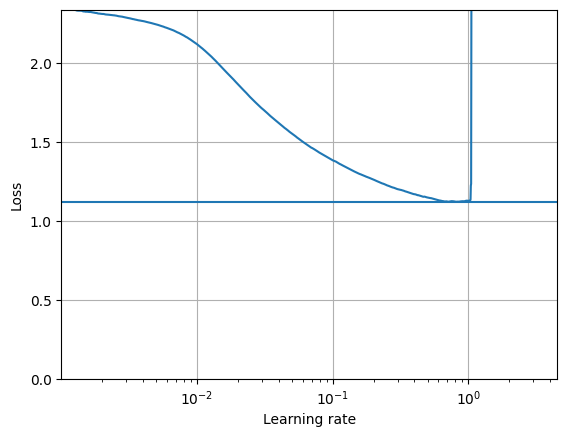

In [94]:

#visualizamos la función de loss según el learning rate
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

Comienza a inestabilizarse cuando se va acercando a 1, pero en 3e-1 todavía es bueno y se va a acercando al menos loss

In [95]:
#repetimos lo anterior
tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
value_seed = 42 #usamos seed para inicialización aleatoria pero repetición de los datos
np.random.seed(value_seed)
tf.random.set_seed(value_seed)

#construimos la red con la api de keras.
#Este es el caso 3 capas ocultas
model_3layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(300, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])

##########################################################################################################################################

value_learning_rate = 3e-1 #valor de inicialización del learning rate
growing_factor = 1.005 #crecimiento del learning rate en un 5% por iteración
optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate) #construimos el optmizador en base a al stochastic gradiente descent
model_3layers.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #compilamos el modelo definiendo la función que queremos usar para el loss, indicándole el optimizador y en qué métrica queremos que se base
expon_lr = ExponentialLearningRate(factor=growing_factor) #aplicamos nuestra clase para poder usar los callbacks y saber el mejor learning rate

In [96]:
#este código es para guardar los pesos
run_index = 1 # increment this at every run
run_logdir = Path() / "logs_3hiddenlayer" / "run_{:03d}".format(run_index)
run_logdir

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("3hiddenlayer_mnist_model", save_best_only=True) #me quedo el mejor y bye lo demás
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_3layers.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1688/1688 [==============================] - ETA: 0s - loss: 0.2651 - accuracy: 0.9171INFO:tensorflow:Assets written to: 3hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 3hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 8s 4ms/step - loss: 0.2651 - accuracy: 0.9171 - val_loss: 0.1394 - val_accuracy: 0.9563
Epoch 2/100
1678/1688 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9676INFO:tensorflow:Assets written to: 3hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 3hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 7s 4ms/step - loss: 0.1067 - accuracy: 0.9676 - val_loss: 0.1090 - val_accuracy: 0.9682
Epoch 3/100
1676/1688 [============================>.] - ETA: 0s - loss: 0.0775 - accuracy: 0.9760INFO:tensorflow:Assets written to: 3hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 3hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 7s 4ms/step - loss: 0.0773 - accuracy: 0.9761 - val_loss: 0.0841 - val_accuracy: 0.9737
Epoch 4/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0580 - accuracy: 0.9824 - val_loss: 0.0886 - val_accuracy: 0.9748
Epoch 5/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0454 - accuracy: 0.9855 - val_loss: 0.0897 - val_accuracy: 0.9765
Epoch 6/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0397 - accuracy: 0.9877 - val_loss: 0.0842 - val_accuracy: 0.9790
Epoch 7/100
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0339 - accuracy: 0.9893 - val_loss: 0.0913 - val_accuracy: 0.9772
Epoch 8/100
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0274 - accuracy: 0.9909 - val_loss: 0.0905 - val_accuracy: 0.9790
Epoch 9/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0230 - accuracy: 0.9924 - val_loss: 0.0842 - val_accuracy: 0.9

In [97]:
model_3hiddenlayer = tf.keras.models.load_model("3hiddenlayer_mnist_model") # rollback to best model
model_3hiddenlayer.evaluate(X_test, y_test) #testeamos qué tal queda

313/313 [==============================] - 1s 2ms/step - loss: 0.0762 - accuracy: 0.9772


[0.07617250084877014, 0.9771999716758728]

Finally, let's look at the learning curves using TensorBoard:

In [98]:
!pip show tensorboard

Name: tensorboard
Version: 2.15.1
Summary: TensorBoard lets you watch Tensors Flow
Home-page: https://github.com/tensorflow/tensorboard
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\niamh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages
Requires: absl-py, google-auth, google-auth-oauthlib, grpcio, markdown, numpy, protobuf, requests, setuptools, six, tensorboard-data-server, werkzeug
Required-by: tensorflow-intel


In [99]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [100]:
import os
print(os.listdir("./logs_3hiddenlayer/run_001"))

['train', 'validation']


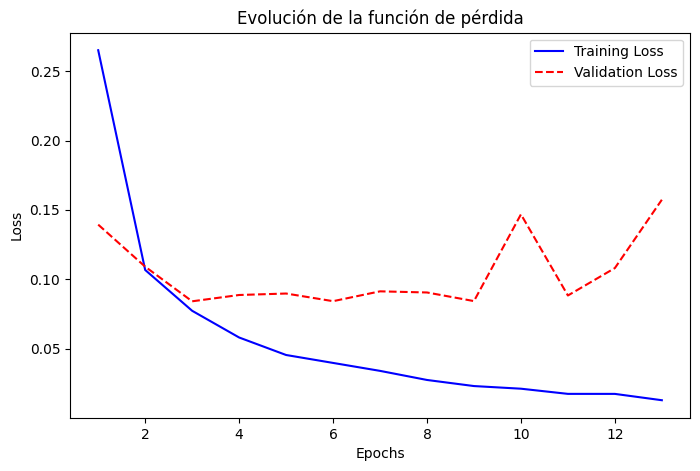

In [101]:
#%tensorboard --logdir=./logs_3hiddenlayer/run_001
# Obtener la pérdida en cada epoch
loss = history.history["loss"]            # Pérdida en entrenamiento
val_loss = history.history["val_loss"]    # Pérdida en validación

epochs = range(1, len(loss) + 1)  # Lista de epochs

# Graficar la pérdida
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evolución de la función de pérdida")
plt.legend()
plt.show()

In [102]:
best_epoch = early_stopping_cb.stopped_epoch - early_stopping_cb.patience
best_epoch

2

1688/1688 [==============================] - 8s 4ms/step - loss: nan - accuracy: 0.5087 - val_loss: nan - val_accuracy: 0.0987


Text(0, 0.5, 'Loss')

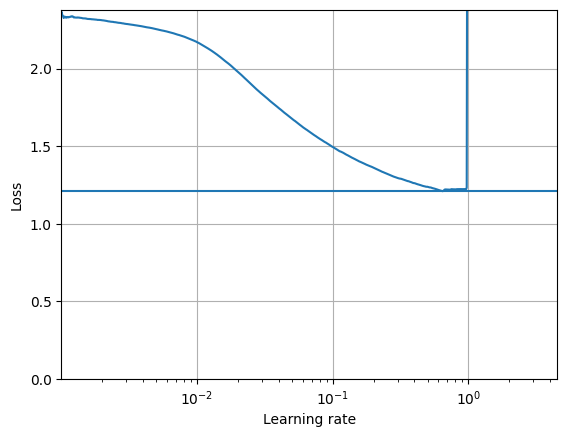

In [103]:
#vamos a repetir pero cambiando el número de neuronas. Vamos a probar con la mitad en cada capa.

tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
value_seed = 42 #usamos seed para inicialización aleatoria pero repetición de los datos
np.random.seed(value_seed)
tf.random.set_seed(value_seed)

#construimos la red con la api de keras.
#Este es el caso 3 capas ocultas
model_3layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(150, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"), 
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])

##########################################################################################################################################

value_learning_rate = 1e-3 #valor de inicialización del learning rate
growing_factor = 1.005 #crecimiento del learning rate en un 5% por iteración
optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate) #construimos el optmizador en base a al stochastic gradiente descent
model_3layers.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #compilamos el modelo definiendo la función que queremos usar para el loss, indicándole el optimizador y en qué métrica queremos que se base
expon_lr = ExponentialLearningRate(factor=growing_factor) #aplicamos nuestra clase para poder usar los callbacks y saber el mejor learning rate

#entrenamos para un sólo epoch. Estos pasos pueden tardar y ser necesario volver para atrás, por lo que se deben vigilar o aplicar early_stopping
#de esa forma evitamos aplicar tiempos excesivos de aprendizaje o el overfitting
history = model_3layers.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])
#visualizamos la función de loss según el learning rate
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [104]:
#repetimos lo anterior
tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
value_seed = 42 #usamos seed para inicialización aleatoria pero repetición de los datos
np.random.seed(value_seed)
tf.random.set_seed(value_seed)

#construimos la red con la api de keras.
#Este es el caso 3 capas ocultas
model_3layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(150, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])

##########################################################################################################################################

value_learning_rate = 3e-1 #valor de inicialización del learning rate
growing_factor = 1.005 #crecimiento del learning rate en un 5% por iteración
optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate) #construimos el optmizador en base a al stochastic gradiente descent
model_3layers.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #compilamos el modelo definiendo la función que queremos usar para el loss, indicándole el optimizador y en qué métrica queremos que se base
expon_lr = ExponentialLearningRate(factor=growing_factor) #aplicamos nuestra clase para poder usar los callbacks y saber el mejor learning rate
#este código es para guardar los pesos
run_index = 1 # increment this at every run
run_logdir = Path() / "logs_3hiddenlayer_2" / "run_{:03d}".format(run_index)
run_logdir

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("3hiddenlayer_2_mnist_model", save_best_only=True) #me quedo el mejor y bye lo demás
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_3layers.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1677/1688 [============================>.] - ETA: 0s - loss: 0.2959 - accuracy: 0.9080INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


1688/1688 [==============================] - 7s 4ms/step - loss: 0.2950 - accuracy: 0.9082 - val_loss: 0.1727 - val_accuracy: 0.9505
Epoch 2/100
1688/1688 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9633INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


1688/1688 [==============================] - 6s 4ms/step - loss: 0.1207 - accuracy: 0.9633 - val_loss: 0.1144 - val_accuracy: 0.9687
Epoch 3/100
1680/1688 [============================>.] - ETA: 0s - loss: 0.0873 - accuracy: 0.9736INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


1688/1688 [==============================] - 6s 4ms/step - loss: 0.0873 - accuracy: 0.9735 - val_loss: 0.1127 - val_accuracy: 0.9675
Epoch 4/100
1686/1688 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9780INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


1688/1688 [==============================] - 6s 4ms/step - loss: 0.0710 - accuracy: 0.9781 - val_loss: 0.0875 - val_accuracy: 0.9775
Epoch 5/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0584 - accuracy: 0.9812 - val_loss: 0.1069 - val_accuracy: 0.9710
Epoch 6/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0468 - accuracy: 0.9853 - val_loss: 0.0891 - val_accuracy: 0.9752
Epoch 7/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0425 - accuracy: 0.9871 - val_loss: 0.1023 - val_accuracy: 0.9765
Epoch 8/100
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0378 - accuracy: 0.9879 - val_loss: 0.0965 - val_accuracy: 0.9757
Epoch 9/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0319 - accuracy: 0.9899 - val_loss: 0.0930 - val_accuracy: 0.9783
Epoch 10/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0299 - accuracy: 0.9909 - val_loss: 0.1013 - val_accuracy: 0.9

INFO:tensorflow:Assets written to: 3hiddenlayer_2_mnist_model\assets


1688/1688 [==============================] - 6s 4ms/step - loss: 0.0275 - accuracy: 0.9914 - val_loss: 0.0855 - val_accuracy: 0.9798
Epoch 12/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0234 - accuracy: 0.9927 - val_loss: 0.1160 - val_accuracy: 0.9750
Epoch 13/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0259 - accuracy: 0.9922 - val_loss: 0.1041 - val_accuracy: 0.9758
Epoch 14/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0229 - accuracy: 0.9930 - val_loss: 0.1014 - val_accuracy: 0.9778
Epoch 15/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0189 - accuracy: 0.9940 - val_loss: 0.0996 - val_accuracy: 0.9787
Epoch 16/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0158 - accuracy: 0.9949 - val_loss: 0.1027 - val_accuracy: 0.9790
Epoch 17/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0191 - accuracy: 0.9945 - val_loss: 0.1020 - val_accuracy

In [105]:
model_3hiddenlayer = tf.keras.models.load_model("3hiddenlayer_2_mnist_model") # rollback to best model
model_3hiddenlayer.evaluate(X_test, y_test) #testeamos qué tal queda

313/313 [==============================] - 1s 2ms/step - loss: 0.0817 - accuracy: 0.9801


[0.08172611147165298, 0.9800999760627747]

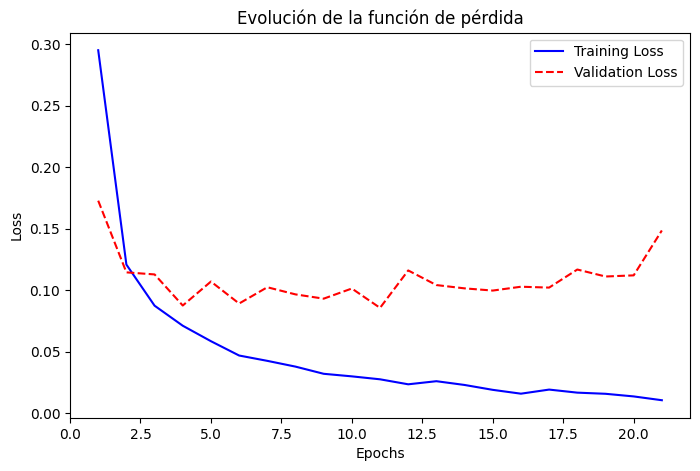

In [106]:
# Obtener la pérdida en cada epoch
loss = history.history["loss"]            # Pérdida en entrenamiento
val_loss = history.history["val_loss"]    # Pérdida en validación

epochs = range(1, len(loss) + 1)  # Lista de epochs

# Graficar la pérdida
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evolución de la función de pérdida")
plt.legend()
plt.show()

PASO 6: Creamos la misma capa pero con 4 capas ocultas

In [107]:
tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
value_seed = 42 #usamos seed para inicialización aleatoria pero repetición de los datos
np.random.seed(value_seed)
tf.random.set_seed(value_seed)

#construimos la red con la api de keras.
#Este es el caso 4 capas ocultas
model_4layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(300, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])

##########################################################################################################################################

value_learning_rate = 1e-3 #valor de inicialización del learning rate
growing_factor = 1.005 #crecimiento del learning rate en un 5% por iteración
optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate) #construimos el optmizador en base a al stochastic gradiente descent
model_4layers.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #compilamos el modelo definiendo la función que queremos usar para el loss, indicándole el optimizador y en qué métrica queremos que se base
expon_lr = ExponentialLearningRate(factor=growing_factor) #aplicamos nuestra clase para poder usar los callbacks y saber el mejor learning rate

In [108]:
#entrenamos para un sólo epoch. Estos pasos pueden tardar y ser necesario volver para atrás, por lo que se deben vigilar o aplicar early_stopping
#de esa forma evitamos aplicar tiempos excesivos de aprendizaje o el overfitting
history = model_4layers.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1688/1688 [==============================] - 8s 5ms/step - loss: nan - accuracy: 0.5197 - val_loss: nan - val_accuracy: 0.0987


Text(0, 0.5, 'Loss')

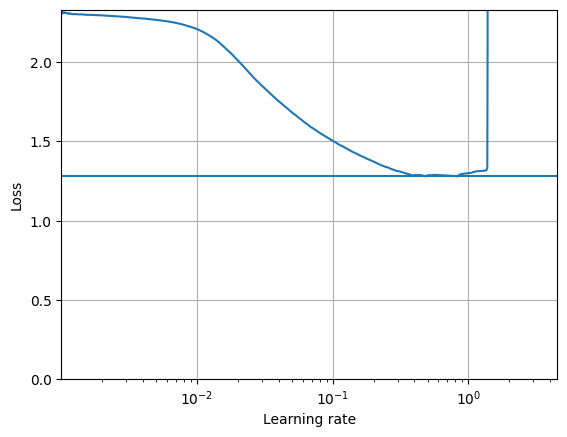

In [109]:
#visualizamos la función de loss según el learning rate
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [110]:
#repetimos lo anterior pero le pondremos el learning rate óptimo
tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
value_seed = 42 #usamos seed para inicialización aleatoria pero repetición de los datos
np.random.seed(value_seed)
tf.random.set_seed(value_seed)

#construimos la red con la api de keras.
#Este es el caso 4 capas ocultas
model_4layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(300, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])

##########################################################################################################################################

value_learning_rate = 5e-1 #valor de inicialización del learning rate
growing_factor = 1.005 #crecimiento del learning rate en un 5% por iteración
optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate) #construimos el optmizador en base a al stochastic gradiente descent
model_4layers.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #compilamos el modelo definiendo la función que queremos usar para el loss, indicándole el optimizador y en qué métrica queremos que se base
expon_lr = ExponentialLearningRate(factor=growing_factor) #aplicamos nuestra clase para poder usar los callbacks y saber el mejor learning rate

In [111]:
#este código es para guardar los pesos
run_index = 1 # increment this at every run
run_logdir = Path() / "logs_4hiddenlayer" / "run_{:03d}".format(run_index)
run_logdir

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("4hiddenlayer_mnist_model", save_best_only=True) #me quedo el mejor y bye lo demás
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_4layers.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1680/1688 [============================>.] - ETA: 0s - loss: 0.4536 - accuracy: 0.8595INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 10s 5ms/step - loss: 0.4523 - accuracy: 0.8599 - val_loss: 0.1817 - val_accuracy: 0.9518
Epoch 2/100
1678/1688 [============================>.] - ETA: 0s - loss: 0.1554 - accuracy: 0.9560INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 7s 4ms/step - loss: 0.1552 - accuracy: 0.9561 - val_loss: 0.1417 - val_accuracy: 0.9625
Epoch 3/100
1687/1688 [============================>.] - ETA: 0s - loss: 0.1122 - accuracy: 0.9690INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 8s 4ms/step - loss: 0.1122 - accuracy: 0.9690 - val_loss: 0.1298 - val_accuracy: 0.9655
Epoch 4/100
1676/1688 [============================>.] - ETA: 0s - loss: 0.0950 - accuracy: 0.9729INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 8s 4ms/step - loss: 0.0951 - accuracy: 0.9728 - val_loss: 0.1008 - val_accuracy: 0.9682
Epoch 5/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0795 - accuracy: 0.9773 - val_loss: 0.1047 - val_accuracy: 0.9740
Epoch 6/100
1681/1688 [============================>.] - ETA: 0s - loss: 0.0630 - accuracy: 0.9814INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 8s 4ms/step - loss: 0.0631 - accuracy: 0.9814 - val_loss: 0.0993 - val_accuracy: 0.9750
Epoch 7/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0589 - accuracy: 0.9834 - val_loss: 0.1050 - val_accuracy: 0.9758
Epoch 8/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0620 - accuracy: 0.9827 - val_loss: 0.1192 - val_accuracy: 0.9717
Epoch 9/100
1688/1688 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9863INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model\assets


1688/1688 [==============================] - 7s 4ms/step - loss: 0.0491 - accuracy: 0.9863 - val_loss: 0.0921 - val_accuracy: 0.9777
Epoch 10/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0452 - accuracy: 0.9872 - val_loss: 0.0996 - val_accuracy: 0.9742
Epoch 11/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0380 - accuracy: 0.9891 - val_loss: 0.1065 - val_accuracy: 0.9765
Epoch 12/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0354 - accuracy: 0.9903 - val_loss: 0.1263 - val_accuracy: 0.9723
Epoch 13/100
1688/1688 [==============================] - 8s 4ms/step - loss: nan - accuracy: 0.5429 - val_loss: nan - val_accuracy: 0.0987
Epoch 14/100
1688/1688 [==============================] - 6s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0987
Epoch 15/100
1688/1688 [==============================] - 6s 4ms/step - loss: nan - accuracy: 0.0987 - val_loss: nan - val_accuracy: 0.0987
Epoch 16/

In [112]:
model_4hiddenlayer = tf.keras.models.load_model("4hiddenlayer_mnist_model") # rollback to best model
model_4hiddenlayer.evaluate(X_test, y_test) #testeamos qué tal queda

313/313 [==============================] - 1s 2ms/step - loss: 0.1050 - accuracy: 0.9750


[0.1050133928656578, 0.9750000238418579]

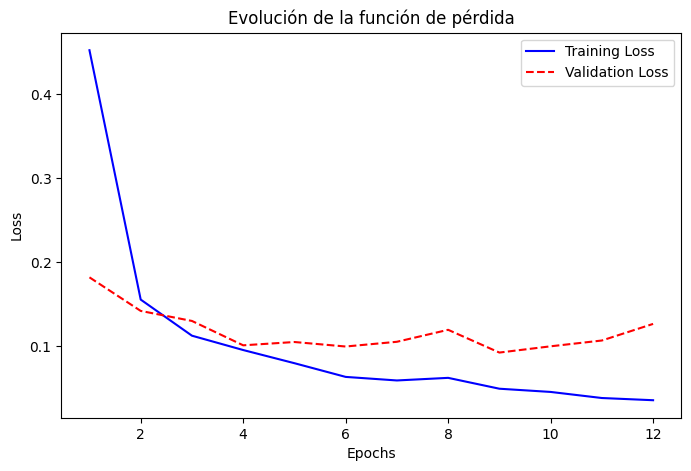

In [113]:
# Obtener la pérdida en cada epoch
loss = history.history["loss"]            # Pérdida en entrenamiento
val_loss = history.history["val_loss"]    # Pérdida en validación

epochs = range(1, len(loss) + 1)  # Lista de epochs

# Graficar la pérdida
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evolución de la función de pérdida")
plt.legend()
plt.show()

1688/1688 [==============================] - 7s 4ms/step - loss: nan - accuracy: 0.4320 - val_loss: nan - val_accuracy: 0.0987


Text(0, 0.5, 'Loss')

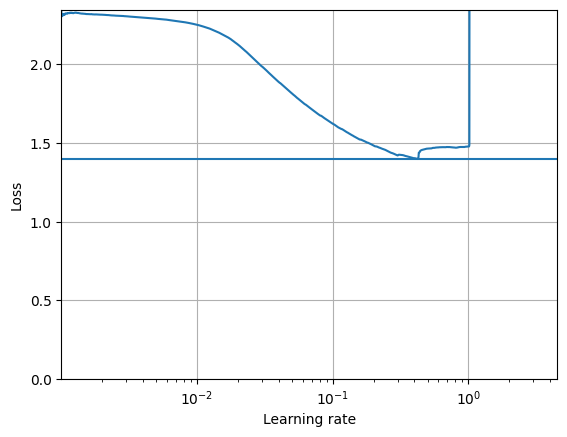

In [114]:
#vamos a repetir pero cambiando el número de neuronas. Vamos a probar con la mitad en cada capa.

tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
value_seed = 42 #usamos seed para inicialización aleatoria pero repetición de los datos
np.random.seed(value_seed)
tf.random.set_seed(value_seed)

#construimos la red con la api de keras.
#Este es el caso 3 capas ocultas
model_4layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(150, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"), 
    tf.keras.layers.Dense(50, activation="relu"), 
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])
 
##########################################################################################################################################

value_learning_rate = 1e-3 #valor de inicialización del learning rate
growing_factor = 1.005 #crecimiento del learning rate en un 5% por iteración
optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate) #construimos el optmizador en base a al stochastic gradiente descent
model_4layers.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #compilamos el modelo definiendo la función que queremos usar para el loss, indicándole el optimizador y en qué métrica queremos que se base
expon_lr = ExponentialLearningRate(factor=growing_factor) #aplicamos nuestra clase para poder usar los callbacks y saber el mejor learning rate

#entrenamos para un sólo epoch. Estos pasos pueden tardar y ser necesario volver para atrás, por lo que se deben vigilar o aplicar early_stopping
#de esa forma evitamos aplicar tiempos excesivos de aprendizaje o el overfitting
history = model_4layers.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])
#visualizamos la función de loss según el learning rate
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [115]:
#repetimos lo anterior pero le pondremos el learning rate óptimo
tf.keras.backend.clear_session() #clear session para evitar empezar con pesos o configuraciones de anteriores runs
value_seed = 42 #usamos seed para inicialización aleatoria pero repetición de los datos
np.random.seed(value_seed)
tf.random.set_seed(value_seed)

#construimos la red con la api de keras.
#Este es el caso 4 capas ocultas
model_4layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(150, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])

##########################################################################################################################################

value_learning_rate = 2e-1 #valor de inicialización del learning rate
growing_factor = 1.005 #crecimiento del learning rate en un 5% por iteración
optimizer = tf.keras.optimizers.SGD(learning_rate=value_learning_rate) #construimos el optmizador en base a al stochastic gradiente descent
model_4layers.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"]) #compilamos el modelo definiendo la función que queremos usar para el loss, indicándole el optimizador y en qué métrica queremos que se base
expon_lr = ExponentialLearningRate(factor=growing_factor) #aplicamos nuestra clase para poder usar los callbacks y saber el mejor learning rate

In [116]:
#este código es para guardar los pesos
run_index = 1 # increment this at every run
run_logdir = Path() / "logs_4hiddenlayer_2" / "run_{:03d}".format(run_index)
run_logdir

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("4hiddenlayer_mnist_model_2", save_best_only=True) #me quedo el mejor y bye lo demás
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_4layers.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1683/1688 [============================>.] - ETA: 0s - loss: 0.3297 - accuracy: 0.8968INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


1688/1688 [==============================] - 6s 3ms/step - loss: 0.3293 - accuracy: 0.8970 - val_loss: 0.1494 - val_accuracy: 0.9543
Epoch 2/100
1678/1688 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9617INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


1688/1688 [==============================] - 5s 3ms/step - loss: 0.1324 - accuracy: 0.9617 - val_loss: 0.1246 - val_accuracy: 0.9642
Epoch 3/100
1677/1688 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9704INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


1688/1688 [==============================] - 6s 3ms/step - loss: 0.0985 - accuracy: 0.9704 - val_loss: 0.1108 - val_accuracy: 0.9695
Epoch 4/100
1676/1688 [============================>.] - ETA: 0s - loss: 0.0770 - accuracy: 0.9765INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


1688/1688 [==============================] - 6s 3ms/step - loss: 0.0768 - accuracy: 0.9765 - val_loss: 0.0846 - val_accuracy: 0.9760
Epoch 5/100
1670/1688 [============================>.] - ETA: 0s - loss: 0.0652 - accuracy: 0.9796INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


1688/1688 [==============================] - 5s 3ms/step - loss: 0.0649 - accuracy: 0.9797 - val_loss: 0.0833 - val_accuracy: 0.9763
Epoch 6/100
1681/1688 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9838INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


INFO:tensorflow:Assets written to: 4hiddenlayer_mnist_model_2\assets


1688/1688 [==============================] - 6s 3ms/step - loss: 0.0536 - accuracy: 0.9838 - val_loss: 0.0744 - val_accuracy: 0.9793
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.0879 - val_accuracy: 0.9758
Epoch 8/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0408 - accuracy: 0.9874 - val_loss: 0.1081 - val_accuracy: 0.9727
Epoch 9/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0361 - accuracy: 0.9887 - val_loss: 0.0857 - val_accuracy: 0.9795
Epoch 10/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0289 - accuracy: 0.9913 - val_loss: 0.0933 - val_accuracy: 0.9797
Epoch 11/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0265 - accuracy: 0.9916 - val_loss: 0.0782 - val_accuracy: 0.9798
Epoch 12/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0249 - accuracy: 0.9917 - val_loss: 0.0793 - val_accuracy: 0

In [117]:
model_4hiddenlayer = tf.keras.models.load_model("4hiddenlayer_mnist_model_2") # rollback to best model
model_4hiddenlayer.evaluate(X_test, y_test) #testeamos qué tal queda

313/313 [==============================] - 1s 2ms/step - loss: 0.0862 - accuracy: 0.9750


[0.08620448410511017, 0.9750000238418579]

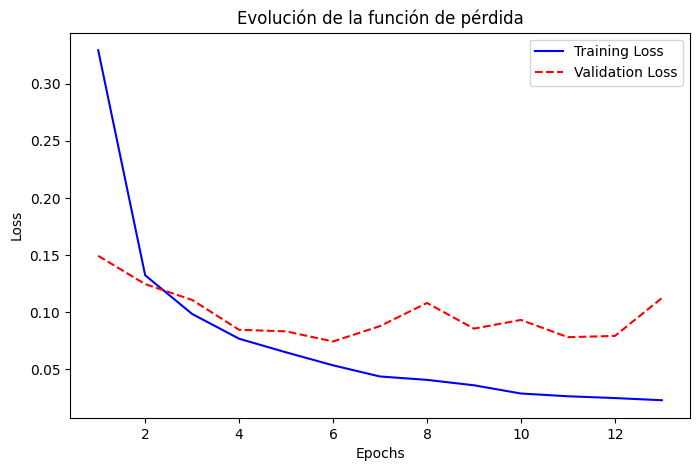

In [118]:
# Obtener la pérdida en cada epoch
loss = history.history["loss"]            # Pérdida en entrenamiento
val_loss = history.history["val_loss"]    # Pérdida en validación

epochs = range(1, len(loss) + 1)  # Lista de epochs

# Graficar la pérdida
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, "b-", label="Training Loss")
plt.plot(epochs, val_loss, "r--", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Evolución de la función de pérdida")
plt.legend()
plt.show()

PASO 7: Metodología para buscar un learning rate óptimo

PASO 8: Keras Tuner

In [119]:
#pip install keras-tuner

In [120]:
import keras_tuner as kt

In [142]:
#capa original
"""
model_3layers = tf.keras.Sequential([ #usamos el modelo secuencial
    tf.keras.layers.Flatten(input_shape=[28, 28]), #las imágenes que tenemos son de 28x28, podemos poner manualmente o son .shape como vimos en el paso 1
    tf.keras.layers.Dense(150, activation="relu"), #ReLU tiene límites lineales. Las imágenes son pequeñas, el contraste alto y los límites definidos.
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax") #el output de salida son valores discretos, por lo que la función de activación más apropaida es "softmax"
])"""

# Función para construir el modelo, con hp la variable proporcionada en la documentación de keras para proporcionar hiperparámetros
# https://keras.io/keras_tuner/

"""def build_model(hp):
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model"""

# combinado con chatgpt
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
    
    for i in range(hp.Int('num_layers', 3, 4)):  
        model.add(tf.keras.layers.Dense(
            hp.Choice(f'units_{i}', [25, 50, 100]),  # Prueba con diferentes números de neuronas
            activation=hp.Choice(f'activation_{i}', ['relu', 'tanh'])  # Prueba ReLU y Tanh
        ))

    model.add(tf.keras.layers.Dense(10, activation='softmax'))  # Capa de salida

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),  # Prueba con Adam y SGD
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [145]:
#Inicializamos el keras_tuner con búsqueda aleatorizada, se añade el modelo a optimizar, el parámetro a optimizar y el máximo número de intentos
tuner = kt.RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 5)

Reloading Tuner from .\untitled_project\tuner0.json


In [146]:
#buscamos el best model
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7) #patience cuanto espero desde que empieza a estabilizarse el loss antes de parar

tuner.search(X_train, y_train, 
             epochs=50, 
             validation_data=(X_valid, y_valid),
             callbacks = [early_stopping_cb])
best_model = tuner.get_best_models()[0]

In [147]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'num_layers': 2, 'units_0': 100, 'activation_0': 'relu', 'optimizer': 'adam', 'units_1': 50, 'activation_1': 'tanh', 'units_2': 50, 'activation_2': 'tanh'}


In [148]:
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, 
                         epochs=10, 
                         validation_data=(X_valid, y_valid))

Epoch 1/10
1688/1688 [==============================] - 7s 4ms/step - loss: 0.2531 - accuracy: 0.9271 - val_loss: 0.1306 - val_accuracy: 0.9597
Epoch 2/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1077 - accuracy: 0.9674 - val_loss: 0.0947 - val_accuracy: 0.9713
Epoch 3/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0761 - accuracy: 0.9767 - val_loss: 0.0892 - val_accuracy: 0.9702
Epoch 4/10
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0575 - accuracy: 0.9818 - val_loss: 0.0862 - val_accuracy: 0.9745
Epoch 5/10
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0452 - accuracy: 0.9854 - val_loss: 0.0891 - val_accuracy: 0.9728
Epoch 6/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0352 - accuracy: 0.9890 - val_loss: 0.0784 - val_accuracy: 0.9785
Epoch 7/10
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0284 - accuracy: 0.9912 - val_loss: 0.0809 - val_accuracy:

In [149]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               78500     
                                                                 
 dense_4 (Dense)             (None, 50)                5050      
                                                                 
 dense_5 (Dense)             (None, 10)                510       
                                                                 
Total params: 84060 (328.36 KB)
Trainable params: 84060 (328.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [150]:
best_model.evaluate(X_test, y_test) #testeamos qué tal queda

313/313 [==============================] - 1s 2ms/step - loss: 0.0968 - accuracy: 0.9757


[0.09678912162780762, 0.9757000207901001]